In [42]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.datasets.cifar10 import load_data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import pandas as pd

## Steps:
- Read the paper
- Download and set up data
- Data augmentation:
+ Read the paper about stain normalization
+ Coding
- Build the model
- Train, test and evaluate
- Write the essay

#### Load data into Keras with ImageGenerator (without augmentation)

### Load image dataset from directory

In [2]:
data_dir = "C:\\Users\\nguyendaithanh\\Desktop\\K_breast\\Data\\train"

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  label_mode='categorical',
  seed=123,
  image_size=(224, 224),
  batch_size=128)
### Load
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='categorical',
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=128)


normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
### Build Residual network

Found 5584 files belonging to 2 classes.
Using 4468 files for training.
Found 5584 files belonging to 2 classes.
Using 1116 files for validation.
0.2520918 1.0


## Build ResNet-based model

In [43]:
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, Add, Dense, Flatten, MaxPooling2D, AveragePooling2D, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
import numpy as np
from keras.regularizers import l2

In [44]:
## Build identity block

def ID_block(input_tensor, filters, stage, block, strides=(1, 1), activation='relu'):
    conv_name_base = "conv" + str(stage) + "_block" + str(block) 

    x = Conv2D(filters, kernel_size=(1,1), strides=strides, padding='same', name = conv_name_base + "_1_conv")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    x = Conv2D(filters, kernel_size= (3,3), strides=strides, padding='same', name = conv_name_base + "_2_conv")(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    x = Conv2D(4*filters, kernel_size= (1,1), strides=strides, padding='same', name = conv_name_base + "_3_conv")(x)
    x = BatchNormalization()(x)

    # Adding shortcut connection
    shortcut = input_tensor

    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x


In [45]:
# Build conv block

def conv_block(input_tensor, filters, stage, block, strides=(1, 1), activation='relu'):
    conv_name_base = "conv" + str(stage) + "_block" + str(block)

    shortcut = input_tensor

    x = Conv2D(filters, kernel_size=(1,1), strides=strides, padding= 'valid', name = conv_name_base + "_1_conv")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    x = Conv2D(filters, kernel_size= (3,3), strides=(1, 1), padding='same', name = conv_name_base + "_2_conv")(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    shortcut = Conv2D(filters*4, kernel_size=(1, 1), strides= strides, padding='valid', name = conv_name_base + "_0_conv")(shortcut)
    shortcut = BatchNormalization()(shortcut)
    
    x = Conv2D(4*filters, kernel_size= (1,1), strides= (1, 1), padding='valid', name = conv_name_base + "_3_conv")(x)
    x = BatchNormalization()(x)

    # Adding shortcut connection
    
    x = Add()([shortcut, x])
    x = Activation(activation)(x)
    return x    

In [46]:
## create function ResNet
def residual_hist(input_tensor):

    ### Level 1 ###

    # padding
    X = ZeroPadding2D((3, 3), name = "pad_1")(input_tensor) 

    # convolution layer, followed by BatchNorm
    X = Conv2D(filters= 64, kernel_size= (7,7), strides= (2, 2), name = "conv1_conv")(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)


    # The next padding
    X = ZeroPadding2D((1, 1), name = "pad_2")(X)
    # maxpooling layer as 5th layer
    X = MaxPooling2D((3, 3), strides= (2, 2))(X)

    ### Level 2 ###

    X = conv_block(X, 64, stage = 2, block = 1)
    X = ID_block(X, 64, stage = 2, block = 2)
    X = ID_block(X, 64, stage = 2, block = 3)

    ### Level 3 ###

    X = conv_block(X, 128, strides= (2, 2), stage = 3, block = 1)
    X = ID_block(X, 128, stage = 3, block = 2)
    X = ID_block(X, 128, stage = 3, block = 3)
    X = ID_block(X, 128, stage = 3, block = 4)

    ### Level 4 ###

    X = conv_block(X, 256, strides= (2, 2), stage = 4, block = 1)
    X = ID_block(X, 256, stage = 4, block = 2)
    X = ID_block(X, 256, stage = 4, block = 3)
    X = ID_block(X, 256, stage = 4, block = 4)
    X = ID_block(X, 256, stage = 4, block = 5)
    X = ID_block(X, 256, stage = 4, block = 6)

    X = AveragePooling2D(pool_size = (7, 7), strides=7)(X)
    X = Flatten()(X)
    X = Dense(2, activation='softmax', activity_regularizer=l2(0.0005))(X)
    
    model = Model(inputs=input_tensor, outputs=X, name = "ResHist")

    return model

### Iniailize weights for model from ResNet50

In [47]:
## Assign weights
def get_weights(model):
    input_t = Input(shape=(224, 224, 3))
    base_model = ResNet50(include_top= False, weights= "imagenet", input_tensor= input_t)

    cweights = {}
    for layer in base_model.layers:
        if isinstance(layer, Conv2D):
            cweights[layer.name] = [layer.get_weights()[0], layer.get_weights()[1]]
    
    i = 0
    for layer in model.layers:
        if isinstance(layer, Conv2D) and i < 40:
            layer.set_weights(cweights[layer.name])
            i += 1

    return model

    

In [48]:
## compile model
from tensorflow.keras.optimizers import Adam
input_tensor = Input((224, 224, 3))
model_5_4 = residual_hist(input_tensor)

model_5_4 = get_weights(model_5_4)

model_5_4.compile(
  optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
  loss='binary_crossentropy',
  metrics=['accuracy'])

In [49]:
len(model_5_4.layers)

146

In [14]:
history_5_4 = model_5_4.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 304s 8s/step - accuracy: 0.7671 - loss: 0.6153 - val_accuracy: 0.7115 - val_loss: 0.6746
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 274s 8s/step - accuracy: 0.9424 - loss: 0.2130 - val_accuracy: 0.7115 - val_loss: 0.6514
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 275s 8s/step - accuracy: 0.9723 - loss: 0.1397 - val_accuracy: 0.7204 - val_loss: 0.6465
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 274s 8s/step - accuracy: 0.9748 - loss: 0.1284 - val_accuracy: 0.7366 - val_loss: 0.6118
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 274s 8s/step - accuracy: 0.9808 - loss: 0.1179 - val_accuracy: 0.5188 - val_loss: 0.7826
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 274s 8s/step - accuracy: 0.9724 - loss: 0.1433 - val_accuracy: 0.6613 - val_loss: 0.6689
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 274s 8s/step - accuracy: 0.9861 - loss: 0.0995 - val_accuracy: 0.7491 - val_loss: 0.5673
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 274s 8s/step - accuracy: 0.9962 - loss: 0.0789 - val_accuracy: 0.8262 - v

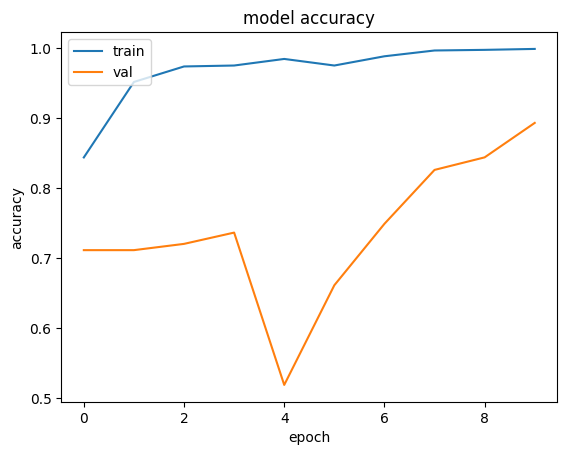

In [15]:
import matplotlib.pyplot as plt

plt.plot(history_5_4.history['accuracy'])
plt.plot(history_5_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

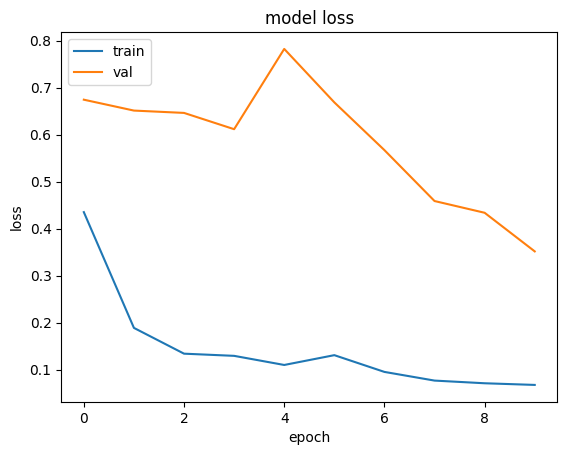

In [16]:
import matplotlib.pyplot as plt

plt.plot(history_5_4.history['loss'])
plt.plot(history_5_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluating on test data

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Test data generator
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',  # Adjust as needed (e.g., 'binary')
    shuffle=False  # Disable shuffling for test set
)

# Evaluate using the test generator
loss, accuracy = model_5_4.evaluate(test_generator)
print(f"Test Accuracy with ImageDataGenerator: {accuracy}")

Found 2325 images belonging to 2 classes.


c:\Users\nguyendaithanh\.conda\envs\K_breast\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7255 - loss: 0.9349
Test Accuracy with ImageDataGenerator: 0.8232257962226868


In [30]:
import os
import numpy as np
import pandas as pd


# Make predictions
predictions = model_5_4.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Get filenames
filenames = test_generator.filenames

# Get class indices (labels)
class_indices = {v: k for k, v in test_generator.class_indices.items()}

# Map indices to class names for true labels and predictions
true_class_names = [class_indices[label] for label in true_labels]
predicted_class_names = [class_indices[label] for label in predicted_classes]

# Create a DataFrame to hold the results
results = pd.DataFrame({
    'Filename': filenames,
    'True Label': true_class_names,
    'Predicted Label': predicted_class_names
})

# Save to CSV
results.to_csv('results.csv', index=False)

print("Results saved to prediction_results.csv")


19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step
Results saved to prediction_results.csv


### Đánh giá trên file csv

In [3]:
import pandas as pd
test_df = pd.read_csv("C:\\Users\\nguyendaithanh\\Desktop\\K_breast\\results.csv")

In [4]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
# Accuracy
print(" Accuracy = ", accuracy_score(test_df["True Label"], test_df["Predicted Label"]))
print(classification_report(test_df["True Label"], test_df["Predicted Label"]))

 Accuracy =  0.8232258064516129
              precision    recall  f1-score   support

      benign       0.79      0.59      0.67       721
   malignant       0.83      0.93      0.88      1604

    accuracy                           0.82      2325
   macro avg       0.81      0.76      0.78      2325
weighted avg       0.82      0.82      0.81      2325



In [5]:
test_df['Patient'] = test_df['Filename'].str.split('-').str.get(2)
test_df['Magnification'] = test_df['Filename'].str.split("\\").str.get(1)

In [6]:
test_df.head()

,Filename,True Label,Predicted Label,Patient,Magnification
0,benign\100X\SOB_B_A-14-22549AB-100-001.png,benign,benign,22549AB,100X
1,benign\100X\SOB_B_A-14-22549AB-100-002.png,benign,benign,22549AB,100X
2,benign\100X\SOB_B_A-14-22549AB-100-003.png,benign,malignant,22549AB,100X
3,benign\100X\SOB_B_A-14-22549AB-100-004.png,benign,benign,22549AB,100X
4,benign\100X\SOB_B_A-14-22549AB-100-005.png,benign,benign,22549AB,100X


In [7]:
### 40X maginification
test_df_40X = test_df[test_df["Magnification"] == "40X"]
print(" Accuracy = ", accuracy_score(test_df_40X["True Label"], test_df_40X["Predicted Label"]))

 Accuracy =  0.8


In [8]:
test_df_100X = test_df[test_df["Magnification"] == "100X"]
print(" Accuracy = ", accuracy_score(test_df_100X["True Label"], test_df_100X["Predicted Label"]))

 Accuracy =  0.8045602605863192


In [9]:
test_df_200X = test_df[test_df["Magnification"] == "200X"]
print(" Accuracy = ", accuracy_score(test_df_200X["True Label"], test_df_200X["Predicted Label"]))

 Accuracy =  0.8830935251798561


In [10]:
test_df_400X = test_df[test_df["Magnification"] == "400X"]
print(" Accuracy = ", accuracy_score(test_df_400X["True Label"], test_df_400X["Predicted Label"]))

 Accuracy =  0.8090909090909091


#### Accuracy patient level

In [26]:
def accuracy_func(x):
    acc = accuracy_score(x["True Label"], x["Predicted Label"])
    return acc
patient = test_df.groupby("Patient").agg(list)


In [34]:
score = patient.apply(accuracy_func, axis=1)

In [35]:
np.mean(score)

0.8100975601106026

In [36]:
patient_40X = test_df[test_df["Magnification"] == '40X'].groupby(["Patient"]).agg(list)
patient_score_40X = np.mean(patient_40X.apply(accuracy_func, axis=1))
patient_score_40X

0.7720065181220461

In [38]:
patient_100X = test_df[test_df["Magnification"] == '100X'].groupby(["Patient"]).agg(list)
patient_score_100X = np.mean(patient_100X.apply(accuracy_func, axis=1))
patient_score_100X

0.7741150950422052

In [39]:
patient_200X = test_df[test_df["Magnification"] == '200X'].groupby(["Patient"]).agg(list)
patient_score_200X = np.mean(patient_200X.apply(accuracy_func, axis=1))
patient_score_200X

0.8775947022339219

In [40]:
patient_400X = test_df[test_df["Magnification"] == '400X'].groupby(["Patient"]).agg(list)
patient_score_400X = np.mean(patient_400X.apply(accuracy_func, axis=1))
patient_score_400X

0.8097217578454902

##
### Data augmentation

In [28]:
import histomicstk.preprocessing.color_normalization.deconvolution_based_normalization as histomic_stain_normal
import histomicstk.utils.convert_image_to_matrix as img_to_matrix
from tensorflow.keras import layers

### Write preprocessing layers for data augmentation

In [86]:
def random_zoom(image, min_zoom=0.8, max_zoom=1.2):
    h, w = image.shape[1:3]
    scale = tf.random.uniform([], min_zoom, max_zoom)
    nh, nw = tf.cast(h * scale, tf.int32), tf.cast(w * scale, tf.int32)
    image = tf.image.resize(image, [nh, nw])
    return tf.image.resize_with_crop_or_pad(image, h, w)

def data_augmentation(image, training=True):
    if training:
        image = tf.image.random_flip_up_down(image)
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=1, maxval=2, dtype=tf.int32))
        #image = tf.image.random_hue(image, max_delta=0.1)
        #image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        #image = random_zoom(image)
    return image

aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [102]:
input_shape = (224, 224, 3)  # example input shape
x = Input(shape=input_shape)
model = residual_hist(x)

model = get_weights(model)

model.compile(
  optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
  loss='binary_crossentropy',
  metrics=['accuracy'])

In [103]:
my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.keras'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
history = model.fit(train_ds, validation_data = val_ds, epochs=15, callbacks= my_callbacks)

Epoch 1/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 375s 10s/step - accuracy: 0.7947 - loss: 0.5127 - val_accuracy: 0.7115 - val_loss: 0.6643
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 337s 10s/step - accuracy: 0.9479 - loss: 0.2015 - val_accuracy: 0.7115 - val_loss: 0.6550
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 344s 10s/step - accuracy: 0.9857 - loss: 0.1134 - val_accuracy: 0.7142 - val_loss: 0.6688
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 343s 10s/step - accuracy: 0.9676 - loss: 0.1368 - val_accuracy: 0.3701 - val_loss: 0.9309
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 342s 10s/step - accuracy: 0.9780 - loss: 0.1229 - val_accuracy: 0.7491 - val_loss: 0.6074
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 344s 10s/step - accuracy: 0.9860 - loss: 0.1008 - val_accuracy: 0.6747 - val_loss: 0.7214
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 341s 10s/step - accuracy: 0.9942 - loss: 0.0803 - val_accuracy: 0.7903 - val_loss: 0.5138
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 347s 10s/step - accuracy: 0.9907 - loss: 0.0932 - val_accuracy: 0.

In [58]:
model_aug_3.save("C:\\Users\\nguyendaithanh\\Desktop\\K_breast\\Model\\ResHist_Aug.h5")

- Show images to see transoformations
- See shape of augment_dataset

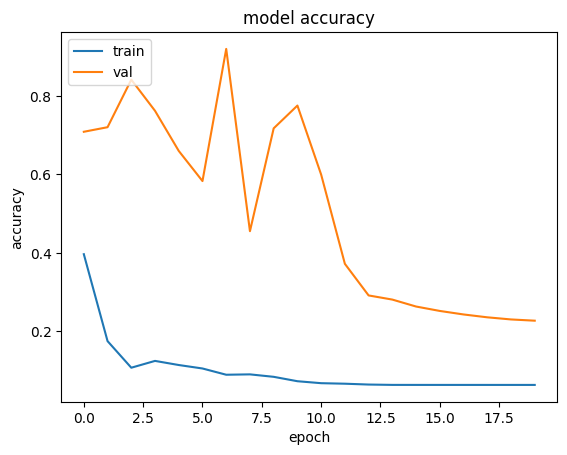

In [95]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluating ResHist_Aug on test data

In [93]:
# Define image data generator for test data
test_dir = "C:\\Users\\nguyendaithanh\\Desktop\\K_breast\\Data\\test"

test_datagen = ImageDataGenerator(rescale=1./255)

# Load and iterate over the test dataset in batches
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Adjust target size as needed
    batch_size=64,
    class_mode='categorical',  # Assuming categorical labels
    shuffle=False,  # Ensure no shuffling
    save_to_dir=None,
    follow_links=True
)


Found 2325 images belonging to 2 classes.


In [62]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

test_dir = "C:\\Users\\nguyendaithanh\\Desktop\\K_breast\\Data\\test"

# Load your trained model
#model = load_model('C:\\Users\\nguyendaithanh\\Desktop\\K_breast\\Model\\ResHist_Aug.h5')


# Define image data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and iterate over the test dataset in batches
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Adjust target size as needed
    batch_size=64,
    class_mode='categorical',  # Assuming categorical labels
    shuffle=False,  # Ensure no shuffling
    save_to_dir=None,
    follow_links=True
)

# Make predictions
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Get filenames
filenames = test_generator.filenames

# Get class indices (labels)
class_indices = {v: k for k, v in test_generator.class_indices.items()}

# Map indices to class names for true labels and predictions
true_class_names = [class_indices[label] for label in true_labels]
predicted_class_names = [class_indices[label] for label in predicted_classes]

# Create a DataFrame to hold the results
results = pd.DataFrame({
    'Filename': filenames,
    'True Label': true_class_names,
    'Predicted Label': predicted_class_names
})

# Save to CSV
results.to_csv('prediction_results_aug.csv', index=False)

print("Results saved to prediction_results.csv")


Found 2325 images belonging to 2 classes.


c:\Users\nguyendaithanh\.conda\envs\K_breast\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step
Results saved to prediction_results.csv


In [107]:
model = load_model("model.12-0.47.keras")

loss, accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7288 - loss: 1.0297


In [39]:
rot_90_ds = train_ds.unbatch().map(lambda x, y: (tf.image.rot90(x), y))
rot_180_ds = train_ds.unbatch().map(lambda x, y: (tf.image.rot90(x, k = 2), y))
flipped_ds = train_ds.unbatch().map(lambda x, y: (tf.image.flip_up_down(x), y))

In [40]:
patches_ds = train_ds.map(lambda x, y: (ExtractPatchesLayer(patch_size= 112, target_size= 224)(x), tf.repeat(y, 6, axis = 0)))

In [532]:
label.shape

TensorShape([2])

In [42]:
# Add rotation 90
aug_ds = train_ds.unbatch().concatenate(rot_90_ds)
# Add rotation 180
aug_ds = aug_ds.concatenate(rot_180_ds)
# Add flip
aug_ds = aug_ds.concatenate(flipped_ds)
# Add histonorm
#aug_ds = aug_ds.concatenate(normalized_dataset)
# Add patches
aug_ds = aug_ds.concatenate(patches_ds.unbatch())

aug_ds = aug_ds.batch(128)


In [48]:
## compile model
from tensorflow.keras.optimizers import Adam
input_shape = (224, 224, 3)  # example input shape
x = Input(shape=input_shape)
model_aug_3 = residual_hist(x)

model_aug_3.compile(
  optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
  loss='binary_crossentropy',
  metrics=['accuracy'])